In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from separate_library import prep_data, split_data, scale_data

from scipy import stats

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = ac.get_telco_data()
encoder, train, validate, test = pr.prep_telco(df)
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (4218, 21)
validate shape = (1407, 20)
    test shape = (1407, 20)


In [3]:
train.head()

,customer_id,gender,senior_citizen,tenure,internet_service_type_id,internet_service_type,device_protection,tech_support,contract_type_id,contract_type,paperless_billing,payment_type_id,payment_type,monthly_charges,total_charges,churn,phone_service_type,family,streaming,online_protection,tenure_years
5767,6885-PKOAM,Female,0,71,1,DSL,Yes,Yes,3,Two year,No,4,Credit card (automatic),85.75,6223.80,0,Multiple lines,Partner,TV and movies,Security and backup,6.0
601,4923-ADWXJ,Female,0,25,1,DSL,No,Yes,1,Month-to-month,Yes,3,Bank transfer (automatic),65.80,1679.65,0,Single line,Single,Movies,Backup,2.0
6469,1099-GODLO,Female,0,1,3,None,No internet service,No internet service,3,Two year,No,2,Mailed check,20.35,20.35,0,Single line,Partner and dependents,No internet service,No internet service,0.0
5729,6374-AFWOX,Male,0,46,1,DSL,Yes,Yes,3,Two year,No,2,Mailed check,65.65,3047.15,0,Single line,Partner,None,Security and backup,4.0
1163,9489-UTFKA,Male,1,8,1,DSL,No,No,1,Month-to-month,No,3,Bank transfer (automatic),60.90,551.95,0,Single line,Partner,TV,Security,1.0


---
# Explore

## 1. If a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

$H_0$: The churn rate for customers whose tenure is less than or equal to one year is the same as all other customers

$H_a$: The churn rate for customers whose tenure is less than or equal to one year is different than all other customers

In [4]:
alpha = .001

x = train[train.tenure_years <= 1].churn
mu = train.churn.mean()

tstat, p = stats.ttest_1samp(x, mu)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

t statistic = 14.767252115963558
    p-value = 2.5543291149045378e-46

Reject the null hypothesis


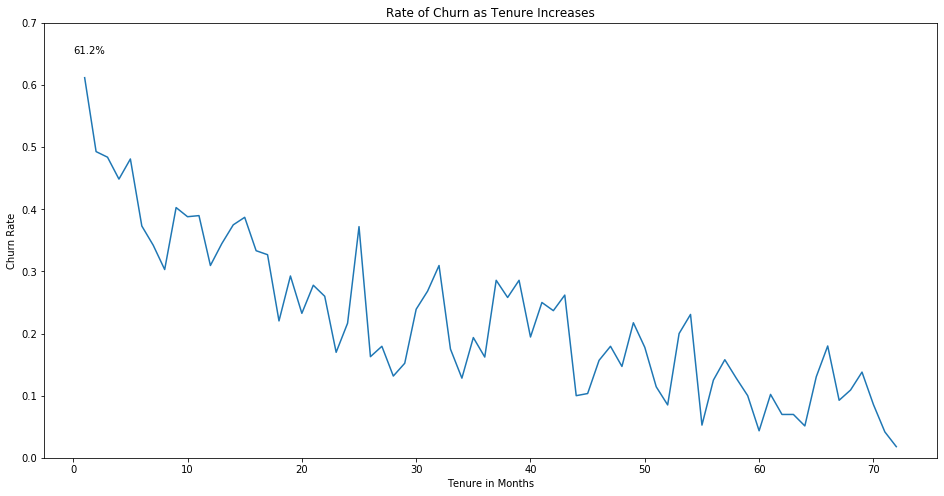

In [5]:
# plotting churn rate by tenure months
monthly = pd.DataFrame({
    "tenure": np.sort(train.tenure.unique()),
})

monthly["churn_rate"] = [((train.churn == 1) & (train.tenure == n)).sum() / (train.tenure == n).sum() for n in monthly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(monthly.tenure, monthly.churn_rate)
plt.text(0, .65, f"{train[train.tenure == 1].churn.mean():.1%}")
plt.xlabel("Tenure in Months")
plt.ylabel("Churn Rate")
plt.ylim(0, .7)
plt.show()

> **Clearly, the rate of churn declines as the customer's tenure with the company increases.**

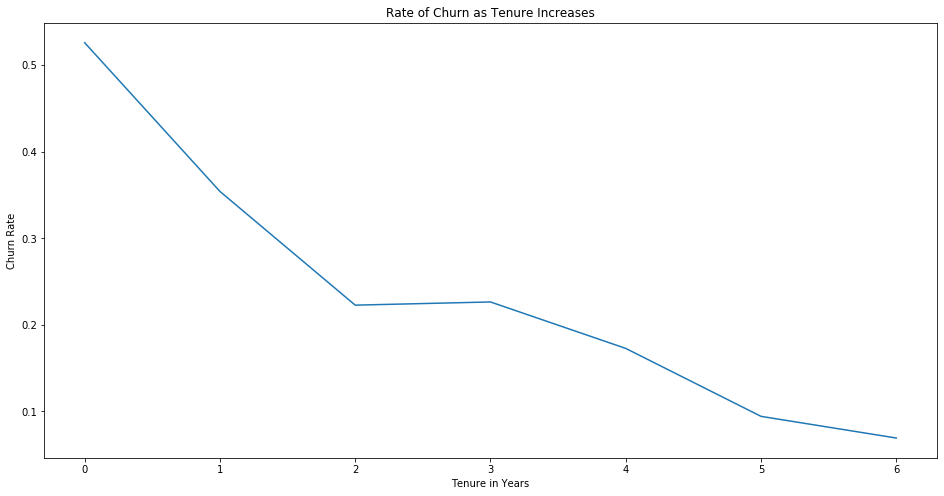

In [6]:
# plotting churn rate by tenure years
yearly = pd.DataFrame({
    "tenure": np.sort(train.tenure_years.unique()),
})

yearly["churn_rate"] = [((train.churn == 1) & (train.tenure_years == n)).sum() / (train.tenure_years == n).sum() for n in yearly.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(yearly.tenure, yearly.churn_rate)
plt.xlabel("Tenure in Years")
plt.ylabel("Churn Rate")
plt.show()

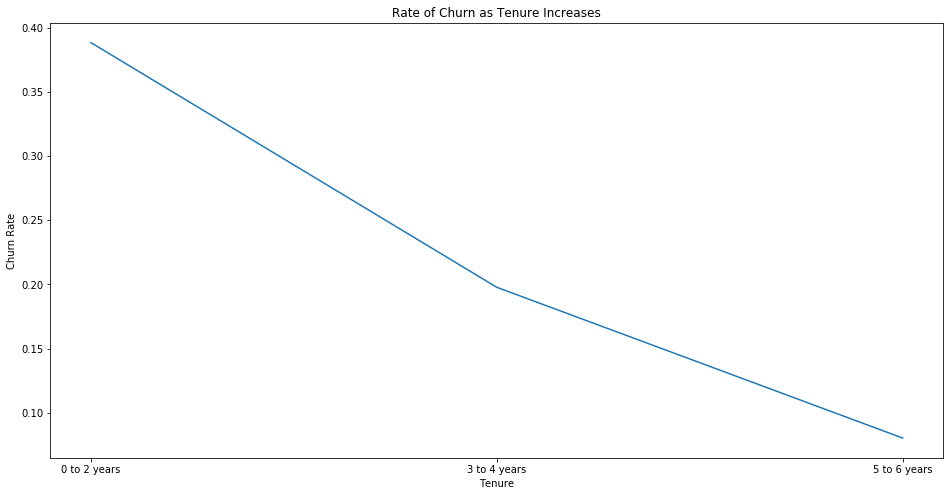

In [7]:
# plotting churn rate by tenure years binned
train["tenure_years_binned"] = pd.cut(train.tenure_years, bins=3, labels=["0 to 2 years", "3 to 4 years", "5 to 6 years"])

binned = pd.DataFrame({
    "tenure": np.sort(train.tenure_years_binned.unique()),
})

binned["churn_rate"] = [((train.churn == 1) & (train.tenure_years_binned == b)).sum() / (train.tenure_years_binned == b).sum() for b in binned.tenure]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Tenure Increases")
plt.plot(binned.tenure, binned.churn_rate)
plt.xlabel("Tenure")
plt.ylabel("Churn Rate")
plt.show()

---
## 2. Are there features that indicate a higher propensity to churn? 

#### Churn Rate by Internet Service Type

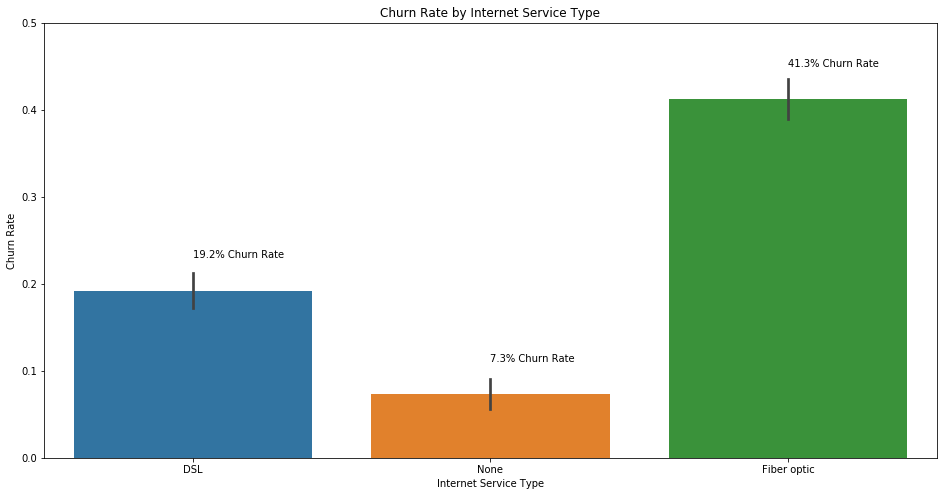

In [8]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Internet Service Type")
sns.barplot(train.internet_service_type, train.churn)
plt.text(0, .23, f"{train[train.internet_service_type == 'DSL'].churn.mean():.1%} Churn Rate")
plt.text(1, .11, f"{train[train.internet_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.text(2, .45, f"{train[train.internet_service_type == 'Fiber optic'].churn.mean():.1%} Churn Rate")
plt.xlabel("Internet Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .5)
plt.show()

> Fiber optic internet service type seems to be a driver of churn. 41.3% of the customers with fiber optic internet service are likely to churn.

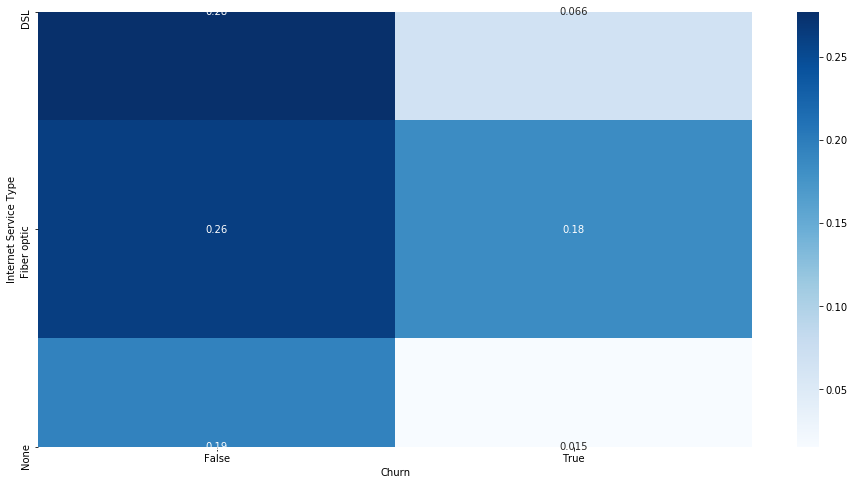

In [9]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.internet_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Internet Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are using fiber optic internet service and have churned make up 18% of all customers.**

---
#### Churn Rate by Phone Service Type

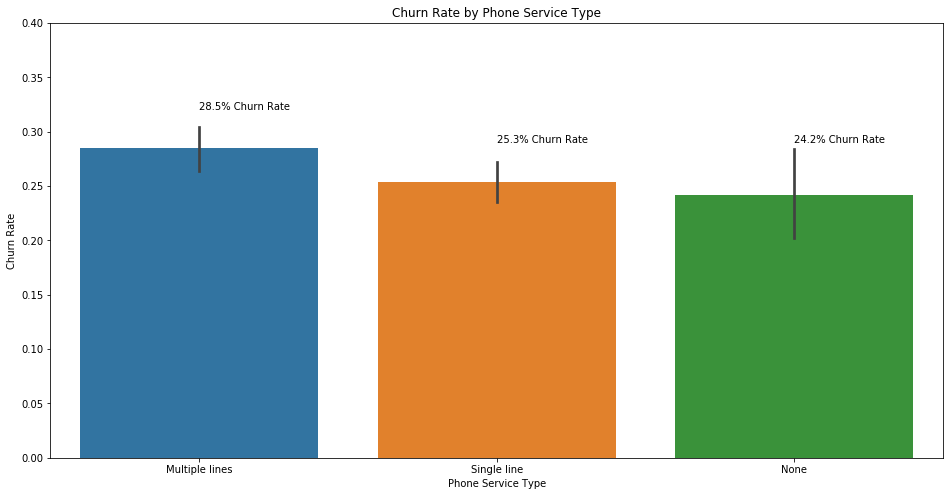

In [10]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Phone Service Type")
sns.barplot(train.phone_service_type, train.churn)
plt.text(0, .32, f"{train[train.phone_service_type == 'Multiple lines'].churn.mean():.1%} Churn Rate")
plt.text(1, .29, f"{train[train.phone_service_type == 'Single line'].churn.mean():.1%} Churn Rate")
plt.text(2, .29, f"{train[train.phone_service_type == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Phone Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, .4)
plt.show()

> **There does not seem to be a significant difference in the churn rate when considering the phone service type**

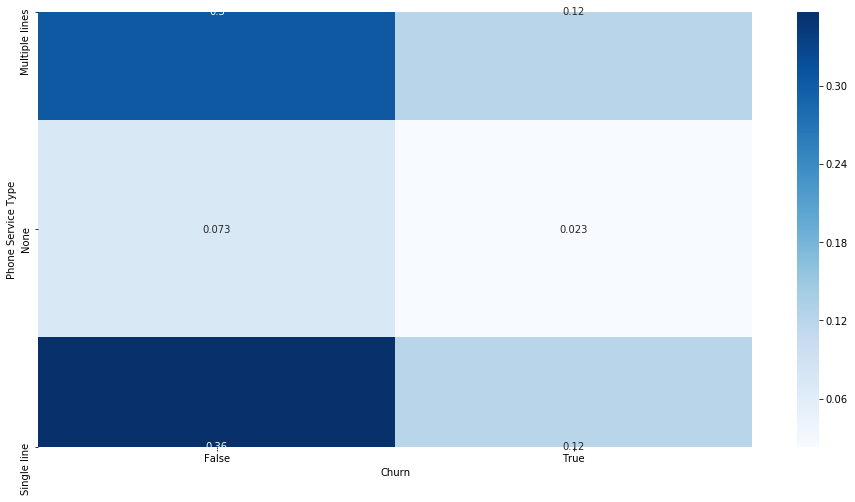

In [11]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.phone_service_type, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Phone Service Type")
plt.xticks((.5, 1.5), (False, True))
plt.show()

---
#### Churn Rate by Online Protection

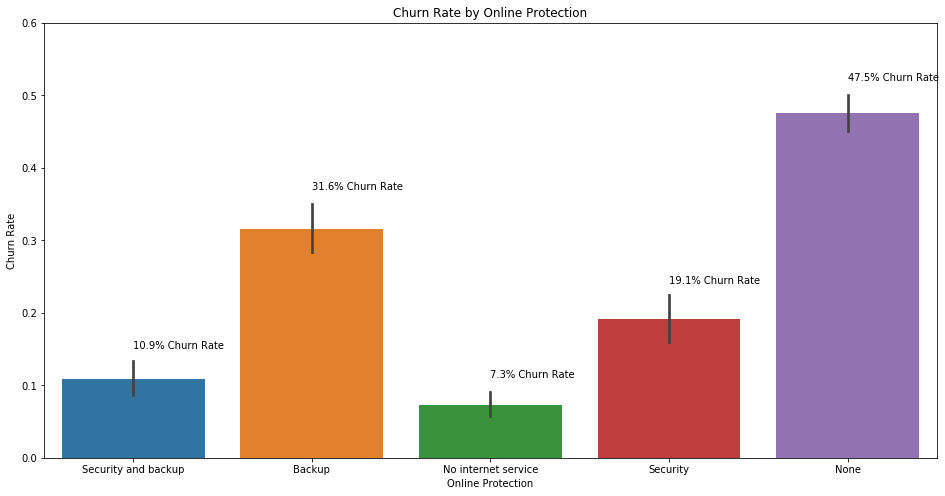

In [12]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Online Protection")
sns.barplot(train.online_protection, train.churn)
plt.text(0, .15, f"{train[train.online_protection == 'Security and backup'].churn.mean():.1%} Churn Rate")
plt.text(1, .37, f"{train[train.online_protection == 'Backup'].churn.mean():.1%} Churn Rate")
plt.text(2, .11, f"{train[train.online_protection == 'No internet service'].churn.mean():.1%} Churn Rate")
plt.text(3, .24, f"{train[train.online_protection == 'Security'].churn.mean():.1%} Churn Rate")
plt.text(4, .52, f"{train[train.online_protection == 'None'].churn.mean():.1%} Churn Rate")
plt.xlabel("Online Protection")
plt.ylabel("Churn Rate")
plt.ylim(0, .6)
plt.show()

> **47.5% of the customers that have no online protection churn.**

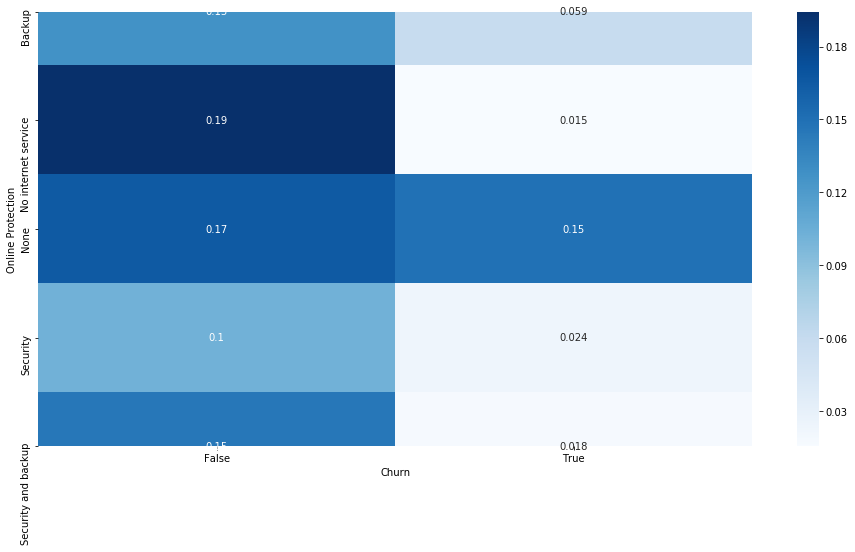

In [13]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.online_protection, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Online Protection")
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who have no online protection plan and who have churned make up 15% of all customers.**

---
#### Churn Rate by Senior Citizen Status

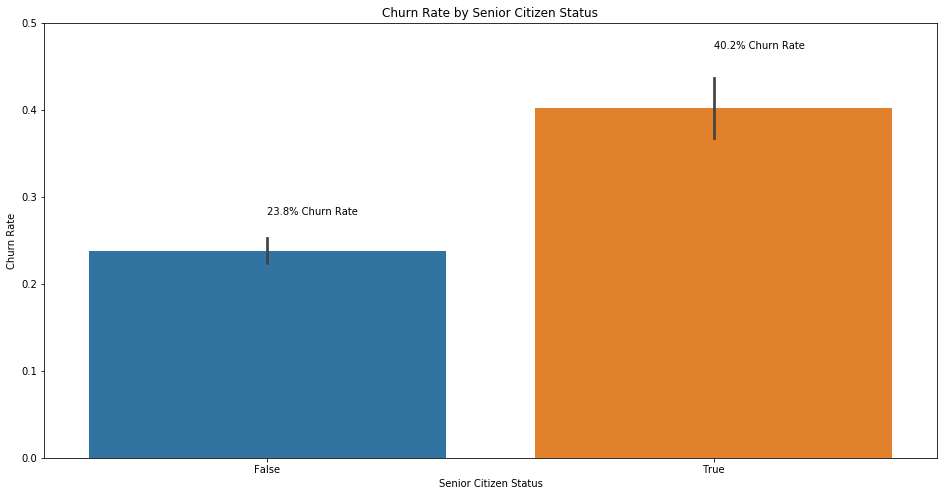

In [14]:
plt.figure(figsize=(16, 8))

plt.title("Churn Rate by Senior Citizen Status")
sns.barplot(train.senior_citizen, train.churn)
plt.text(0, .28, f"{train[train.senior_citizen == 0].churn.mean():.1%} Churn Rate")
plt.text(1, .47, f"{train[train.senior_citizen == 1].churn.mean():.1%} Churn Rate")
plt.xlabel("Senior Citizen Status")
plt.ylabel("Churn Rate")
plt.xticks((0, 1), (False, True))
plt.ylim(0, .5)
plt.show()

> **40.2% of all senior citizens churn**

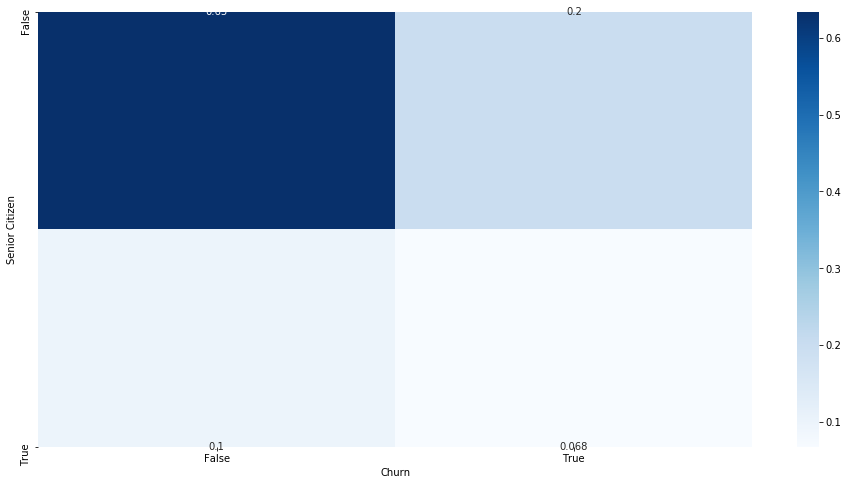

In [15]:
plt.figure(figsize=(16, 8))

ctab = pd.crosstab(index=train.senior_citizen, columns=train.churn, normalize=True)
sns.heatmap(ctab, annot=True, cmap="Blues")
plt.xlabel("Churn")
plt.ylabel("Senior Citizen")
plt.yticks((.5, 1.5), (False, True))
plt.xticks((.5, 1.5), (False, True))
plt.show()

> **Customers who are not senior citizens and who have churned make up 20% of all customers.**

---
## 3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

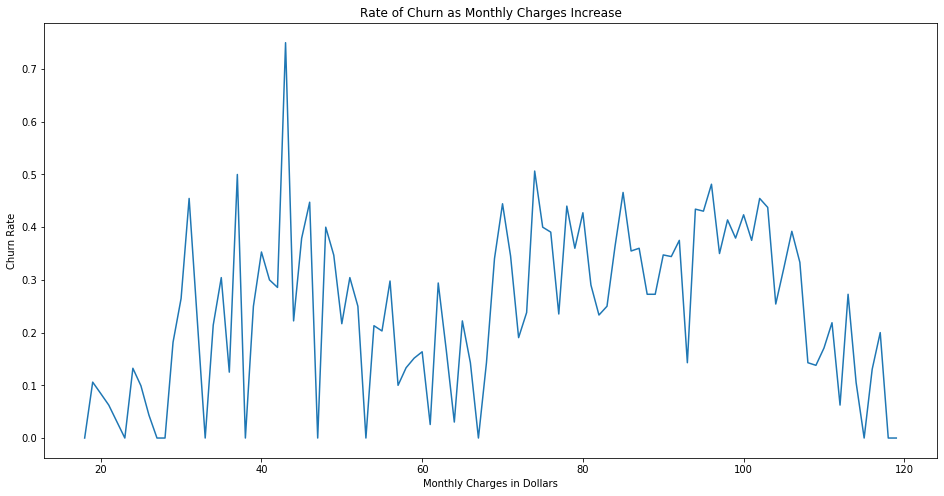

In [16]:
# plotting churn rate by monthly_charges
monthly_charges = pd.DataFrame({
    "charges": np.sort(train.monthly_charges.round().unique()),
})

monthly_charges["churn_rate"] = [((train.churn == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in monthly_charges.charges]

plt.figure(figsize=(16, 8))

plt.title("Rate of Churn as Monthly Charges Increase")
plt.plot(monthly_charges.charges, monthly_charges.churn_rate)
plt.xlabel("Monthly Charges in Dollars")
plt.ylabel("Churn Rate")
plt.show()

In [17]:
# # plotting churn rate by monthly_charges
# dsl_monthly_charges = pd.DataFrame({
#     "charges": np.sort(train[train.internet_service_type == "DSL"].monthly_charges.round().unique()),
# })

# monthly_charges["churn_rate"] = [((train.churn == 1) & (train.monthly_charges.round() == n)).sum() / (train.monthly_charges.round() == n).sum() for n in dsl_monthly_charges.charges]

# plt.figure(figsize=(16, 8))

# plt.title("Rate of Churn as Monthly Charges Increase")
# plt.plot(dsl_monthly_charges.charges, dsl_monthly_charges.churn_rate)
# plt.xlabel("Monthly Charges in Dollars")
# plt.ylabel("Churn Rate")
# plt.show()

---
## 4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$H_0$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is the same

$H_a$: The churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month is different

In [18]:
alpha = .001

month_to_month = train[(train.contract_type == "Month-to-month") & (train.tenure > 12)].churn
annual = train[(train.contract_type == "One year") & (train.tenure > 12)].churn

tstat, p = stats.ttest_ind(month_to_month, annual)
print(f"t statistic = {tstat}")
print(f"    p-value = {p}")
print()
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
print()
print(f"The churn rate for month-to-month customers after the 12th month is {month_to_month.mean():.1%}")
print(f"The churn rate for 1-year contract customers after the 12th month is {annual.mean():.1%}")
print()
print("""It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition""")

t statistic = 10.939201115216212
    p-value = 4.6357843354484826e-27

Reject the null hypothesis

The churn rate for month-to-month customers after the 12th month is 33.0%
The churn rate for 1-year contract customers after the 12th month is 11.8%

It can be stated with 99.9% certainty that month-to-month customers after the 12th month churn at almost
3x the rate of 1-year contract customers after the 12th month.

Takeaway: If we are trying to reduce churn, we should be more aggressive in contract aquisition


---
# Model

1. build a function takes in all selected features, 

2. function produce accuray for each algirthom
3. logistic regression is the baseline

In [19]:
# all the feature has been already encoded with separated preparation
# split data
df = prep_data()
train, validate, test = split_data(df, .8)
#scale datasets
scaler, train, validate, test = scale_data(train, validate, test)
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,churn
3221,1,1,0,0.267606,1,0,2,0,0,0,0,1,1,2,1,3,0.724551,0
3076,0,0,0,0.746479,1,0,2,1,0,1,0,1,0,1,0,2,0.712575,0
4825,0,0,0,0.154930,1,0,1,0,1,0,0,0,0,1,1,1,0.309381,0
5571,0,0,0,0.000000,0,0,1,0,1,0,1,0,1,1,1,2,0.261976,1
6967,0,1,1,0.478873,0,0,1,1,0,0,1,1,0,3,1,4,0.278942,0


In [20]:
# Name features 
X = train.drop(columns = 'churn').columns
y = ['churn']

In [21]:
# apply to train, validate, test
X_train = train[X]
y_train = train[y]
X_validate = validate[X]
y_validate = validate[y]
X_test = test[X]
y_test = test[y]

## 2. Make a function

In [22]:
def model_evaluation(X, y):
    # get prepared data
    df = prep_data()
    # split data
    train, validate, test = split_data(df, .8)
    # assaign X, y to different data set
    X_train = train[X]
    y_train = train[y]
    X_validate = validate[X]
    y_validate = validate[y]
    X_test = test[X]
    y_test = test[y]
    # train different models
    ## logiestic regression
    logit = LogisticRegression(random_state = 123)
    logit.fit(X_train, y_train)
    ## random forest
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            #max_depth=20, 
                            random_state=123)
    rf.fit(X_train, y_train)
    ## KNN
    knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
    knn.fit(X_train, y_train)
    return pd.DataFrame({'logistic_regression': [logit.score(X_train, y_train),logit.score(X_validate, y_validate)],
              'random_forest': [rf.score(X_train, y_train),rf.score(X_validate, y_validate)], 
              'KNN': [knn.score(X_train, y_train),knn.score(X_validate, y_validate)]}, index = ['train','validate'])

## 3.  Try model performance with different features

In [23]:
df.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract_type_id', 'paperless_billing',
       'payment_type_id', 'monthly_charges', 'churn'],
      dtype='object')

### 1. Main features

In [24]:
X = ['tenure','monthly_charges','contract_type_id','senior_citizen']
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.788222,0.891778,0.818889
validate,0.819556,0.814222,0.808889


### 2. Other features

In [25]:
X = ['senior_citizen', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'internet_service_type_id', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing',
       'payment_type_id']
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.758667,0.814222,0.796222
validate,0.791111,0.787556,0.776889


### 3. All features

In [26]:
X = train.drop(columns = 'churn').columns
y = ['churn']
model_evaluation(X, y)

,logistic_regression,random_forest,KNN
train,0.798889,0.892222,0.824889
validate,0.836444,0.831111,0.810667


**Takeaways**
1. `tenure`,`monthly_charges`,`contract_type_id`: these three features give me a good accuracy, by adding other features, it did not increase acurracy very much
2. I assume all the `other features` has high correlation with `onthly charges`
3. `Random_forest` algrithm generate the best model performance, so this is what we are going to use.

## 4. Apply best performance model to the test data set,  get the report and csv file

In [27]:
X = ['tenure','monthly_charges','contract_type_id','senior_citizen']
y = ['churn']
X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

In [28]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=20, 
                            random_state=123)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

### 1. classifcation_report

In [29]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.818018,0.565657,0.764748,0.691837,0.751654
recall,0.875603,0.454054,0.764748,0.664828,0.764748
f1-score,0.845831,0.503748,0.764748,0.674790,0.755873
support,1037.000000,370.000000,0.764748,1407.000000,1407.000000


### 2. Confusion matrix

In [30]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,908,129
1,202,168


### 3. Accuracy

In [31]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.76


### 4. Export prediction into a .csv file

In [32]:
df = ac.get_telco_data()
df = df[['customer_id','tenure','monthly_charges','contract_type_id','senior_citizen','churn']]
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn
0,0003-MKNFE,9,59.9,1,0,No
1,0013-MHZWF,9,69.4,1,0,No
2,0015-UOCOJ,7,48.2,1,1,No
3,0023-HGHWL,1,25.1,1,1,Yes
4,0032-PGELS,1,30.5,1,0,Yes


In [33]:
df[["tenure", "monthly_charges"]] = scaler.transform(df[["tenure", "monthly_charges"]])
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn
0,0003-MKNFE,0.112676,0.414172,1,0,No
1,0013-MHZWF,0.112676,0.508982,1,0,No
2,0015-UOCOJ,0.084507,0.297405,1,1,No
3,0023-HGHWL,0.000000,0.066866,1,1,Yes
4,0032-PGELS,0.000000,0.120758,1,0,Yes


In [34]:
df['predicted']= rf.predict(df[['tenure',
                                'monthly_charges',
                                'contract_type_id',
                                'senior_citizen']])

In [35]:
df['predicted'] = df.predicted.apply(lambda x: 'Yes' if x == 1 else 'No')
df.head()

,customer_id,tenure,monthly_charges,contract_type_id,senior_citizen,churn,predicted
0,0003-MKNFE,0.112676,0.414172,1,0,No,No
1,0013-MHZWF,0.112676,0.508982,1,0,No,No
2,0015-UOCOJ,0.084507,0.297405,1,1,No,No
3,0023-HGHWL,0.000000,0.066866,1,1,Yes,Yes
4,0032-PGELS,0.000000,0.120758,1,0,Yes,Yes


In [36]:
df = df.rename(columns = {'churn': 'actual'})
df = df[['customer_id','actual','predicted']]
df.head()

,customer_id,actual,predicted
0,0003-MKNFE,No,No
1,0013-MHZWF,No,No
2,0015-UOCOJ,No,No
3,0023-HGHWL,Yes,Yes
4,0032-PGELS,Yes,Yes


In [37]:
#df.to_csv('prediction.csv')